In [66]:
from path import Path
from scipy.stats import pearsonr, spearmanr, wilcoxon

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import os, warnings 
warnings.filterwarnings('ignore') 
import stan

figsize = stan.figsize
fontsize = stan.fontsize
dpi = stan.dpi

path = Path('df2plot_inR')
if not os.path.exists(path):
    os.makedirs(path)

## Loading ST dataset

In [ ]:
sample_id = "Parent_Visium_Human_Glioblastoma"

# Input of STAN
adata = stan.read_visium_sge(sample_id=sample_id, min_cells=5, min_counts=500)
# output of STAN
adata_stan = sc.read_h5ad(f"outputs_stan/adata_{sample_id}.h5ad")

Extract the inferred TF activity matrix.

In [ ]:
# ridge
adata_stan.obsm['tfa_ridge'] = pd.read_csv(f'outputs_stan/adata_{sample_id}_tfa_ridge.csv', index_col=0)
adata_stan.obs['pred_cor_ridge'] = pd.read_csv(f'outputs_stan/adata_{sample_id}_pred_cor_ridge.csv', index_col=0)

# decoupler
adata.obsm['ulm_estimate'] = pd.read_csv(f'benchmark_decoupler/ulm_{sample_id}.csv', index_col=0).loc[adata.obs.index,:]

In [ ]:
adata_tfa = stan.get_activity(adata_stan, key='tfa_stan')
adata_tfa_ridge = stan.get_activity(adata_stan, key='tfa_ridge')
adata_tfa_dec = stan.get_activity(adata, key='ulm_estimate')

For mRNA expression, normalize each spot by total counts over all genes

In [ ]:
sc.pp.normalize_total(adata)
adata.layers['scaled'] = np.sqrt(adata.to_df())

sc.pp.normalize_total(adata_stan)
adata_stan.layers['scaled'] = np.sqrt(adata_stan.to_df())

## Visualizing the cross validation performance

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adata, show=False, ax=ax, title="Parent_Visium\nHuman_Glioblastoma")
ax.set_xlabel("")
ax.set_ylabel("")

In [ ]:
stan.plot_validation(adata_stan, title='Cross Validation Performance\n(Pearson r, Human_Glioblastoma')

In [ ]:
print(adata_stan.obs["pred_cor_stan"].mean())
print(adata_stan.obs["pred_cor_stan"].std())
print(adata_stan.obs["pred_cor_ridge"].mean())
print(adata_stan.obs["pred_cor_ridge"].std())

In [ ]:
wilcoxon(adata_stan.obs["pred_cor_stan"], adata_stan.obs["pred_cor_ridge"], 
         zero_method='wilcox', correction=False, alternative='greater')

In [ ]:
pearsonr(adata_stan.obs["pred_cor_stan"]-adata_stan.obs["pred_cor_ridge"],
         adata_stan.obs["n_counts"])

## Embedding and Clustering
### Clustering based on TF Activity

In [ ]:
adata_tfa_scaled = adata_tfa.copy()
sc.pp.scale(adata_tfa_scaled)
sc.pp.neighbors(adata_tfa_scaled, n_neighbors=100)
sc.tl.umap(adata_tfa_scaled, min_dist=0.01)
sc.tl.leiden(adata_tfa_scaled, resolution=0.36)
stan.plot_umap(adata_tfa_scaled, title='Clustering based on TF Activity (STAN)')

### Clustering based on mRNA expression
The spatial distribution based on mRNA expression is noisier and less precise.

In [ ]:
tfs = adata.var_names.intersection(adata_stan.varm['gene_tf'].columns)
adata_scaled = adata.copy()
sc.pp.log1p(adata_scaled)
sc.pp.scale(adata_scaled)
adata_scaled_subset = adata_scaled[:, tfs].copy()
sc.pp.neighbors(adata_scaled_subset, n_neighbors=100)
sc.tl.umap(adata_scaled_subset, min_dist=0.01)
sc.tl.leiden(adata_scaled_subset, resolution=0.8) # res = 1
stan.plot_umap(adata_scaled_subset, title='Clustering based on mRNA Expression of TFs')

## Correlating TFs and genes
We obtained a list of human ligand-receptor interaction pairs from the [CellTalkDB](https://academic.oup.com/bib/article/22/4/bbaa269/5955941) [database](https://github.com/ZJUFanLab/CellTalkDB/tree/master/database), which includes 3,398 available ligand-receptor interaction pairs from among 815 ligands and 780 receptors.

In [ ]:
df_lr_pair = pd.read_csv('resources/human_lr_pair.csv', index_col=0)
lr_list = list(set(df_lr_pair['ligand_gene_symbol']).union(set(df_lr_pair['receptor_gene_symbol'])))
lr_list = np.intersect1d(adata.var_names, lr_list).tolist()

mat = stan.compute_spatial_expression(adata, list(adata.var_names))
mat_tf = adata_tfa.to_df()


In [ ]:
ligand_list = list(set(df_lr_pair['ligand_gene_symbol']))
ligand_list = np.intersect1d(adata.var_names, ligand_list).tolist()
print(len(ligand_list))

receptor_list = list(set(df_lr_pair['receptor_gene_symbol']))
receptor_list = np.intersect1d(adata.var_names, receptor_list).tolist()
print(len(receptor_list))

In [ ]:
df_corr_tl = pd.DataFrame({x: mat_tf.corrwith(mat[x]) for x in ligand_list})
print(df_corr_tl.shape)
df_corr_tr = pd.DataFrame({x: mat_tf.corrwith(mat[x]) for x in receptor_list}) 
print(df_corr_tr.shape)
df_corr_lr = pd.DataFrame({x: mat[ligand_list].corrwith(mat[x]) for x in receptor_list}) 
print(df_corr_lr.shape)

In [ ]:
from path import Path
path = Path('results_glioblastoma')
os.makedirs(path, exist_ok=True)

df_corr_lr.to_csv(path/'corr_lr.csv')
df_corr_tr.to_csv(path/'corr_tr.csv')
df_corr_tl.to_csv(path/'corr_tl.csv')

### Plot the correlation heatmaps in R

In [ ]:
df_corr_tl = pd.read_csv('results_glioblastoma/corr_tl.csv', index_col=0)
df_corr_tr = pd.read_csv('results_glioblastoma/corr_tr.csv', index_col=0)
df_corr_lr = pd.read_csv('results_glioblastoma/corr_lr.csv', index_col=0)

tf_list = df_corr_tl.index
ligand_list = df_corr_tl.columns
receptor_list = df_corr_lr.columns

In [ ]:
thre = 0.57
tfs = []
for tf in tf_list:
    if df_corr_tl.loc[tf,:].max()>thre and df_corr_tr.loc[tf,:].max()>thre:
        tfs.append(tf)
        
ligands = []
for ligand in ligand_list:
    if df_corr_tl.loc[:,ligand].max()>thre and df_corr_lr.loc[ligand,:].max()>thre:
        ligands.append(ligand)

receptors = []
for receptor in receptor_list:
    if df_corr_tr.loc[:,receptor].max()>thre and df_corr_lr.loc[:,receptor].max()>thre:
        receptors.append(receptor) 

In [ ]:
print((tfs))
print((ligands))
print((receptors))

In [ ]:
print(len(tfs))
print(len(ligands))
print(len(receptors))

In [ ]:
df_corr_tl.loc[tfs, ligands].to_csv('df2plot_inR/gbm_corr_tl.csv')
df_corr_tr.loc[tfs, receptors].to_csv('df2plot_inR/gbm_corr_tr.csv')
df_corr_lr.loc[ligands, receptors].to_csv('df2plot_inR/gbm_corr_lr.csv')

### Spatial plots of TFs, ligands, and receptors

In [72]:
def plot_spatial_map(ligand, receptor, tf):
    fig, axs = plt.subplots(4,1, figsize=(figsize, figsize*4), dpi=dpi)
#     fig, axs = plt.subplots(3,1, figsize=(figsize, figsize*3), dpi=dpi)
    sc.pl.spatial(adata, color=ligand, alpha_img=0, ax=axs[0],show=False, cmap="viridis", 
                  legend_fontsize=fontsize, size=1.8)
    sc.pl.spatial(adata, color=receptor, alpha_img=0, ax=axs[1],show=False, cmap="viridis", 
                  legend_fontsize=fontsize, size=1.8)
    sc.pl.spatial(adata_tfa, color=tf, alpha_img=0, ax=axs[2],show=False, cmap="plasma", 
                  legend_fontsize=fontsize, size=1.8)
    sc.pl.spatial(adata, color=tf, alpha_img=0, ax=axs[3],show=False, cmap="viridis", 
                  legend_fontsize=fontsize, size=1.8)
    axs[0].set_title(ligand + ' mRNA expr', fontsize=fontsize)
    axs[1].set_title(receptor + ' mRNA expr', fontsize=fontsize)
    axs[2].set_title(tf + ' activity', fontsize=fontsize)
    axs[3].set_title(tf + ' mRNA expr', fontsize=fontsize)
    for i in range(4):
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")

In [ ]:
adata = stan.read_visium_sge(sample_id=sample_id, min_cells=5, min_counts=500)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

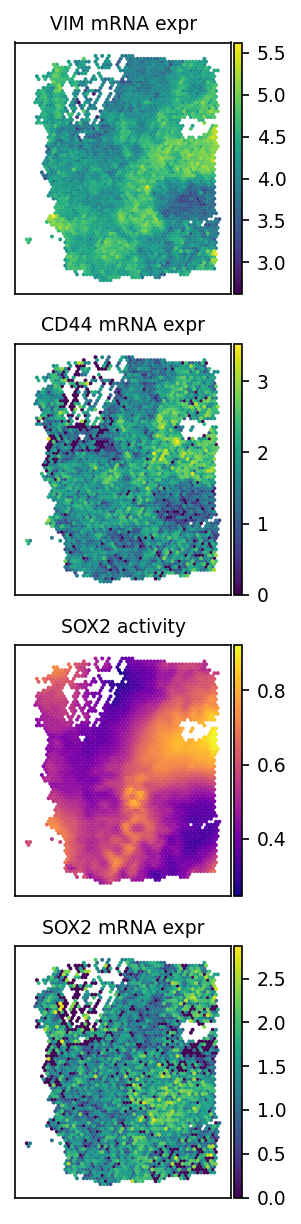

In [73]:
plot_spatial_map('VIM', 'CD44', 'SOX2')

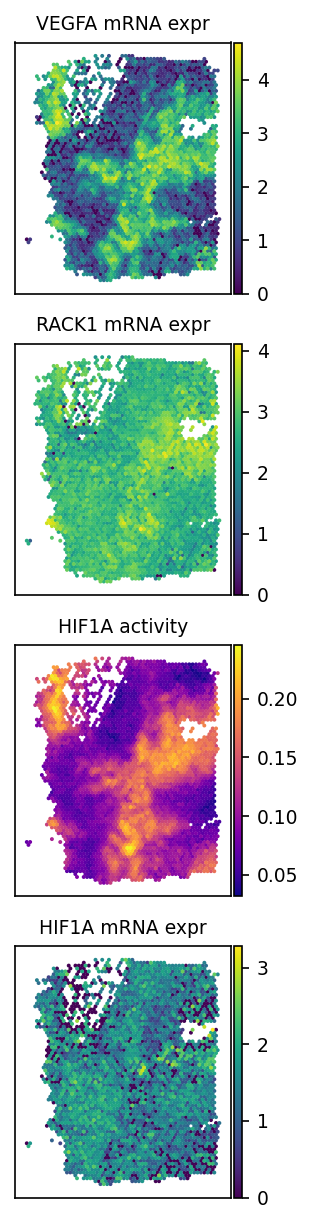

In [74]:
plot_spatial_map('VEGFA', 'RACK1', 'HIF1A')